# **Syed Mohd Haider Rizvi**
**Roll No. MT23AAI023**

# Neural Network Architectural Detail Computation

This Google Colab notebook implements a Python function for computing the architectural details of neural network layers, focusing on convolution and dense layers. We'll then use this function to analyze the GoogleNet architecture.

## 1. Implementation of the Architectural Detail Function

First, let's import necessary libraries:


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Markdown
import seaborn as sns

Now, let's define our main function:

In [ ]:
def arch_detail(layer_type, input_dim, **kwargs):
    """
    Compute architectural details for neural network layers.

    Parameters:
    -----------
    layer_type : str
        Type of layer ('conv', 'dense')
    input_dim : tuple
        Dimensions of input:
        - For conv: (height, width, channels)
        - For dense: (nodes,)
    **kwargs : dict
        Layer-specific parameters:
        - For conv layers: filter_h, filter_w, stride, padding, num_filters
        - For dense layers: num_nodes

    Returns:
    --------
    tuple
        (output_dimensions, trainable_parameters, dot_products, total_computations)
        - output_dimensions: shape of the output tensor
        - trainable_parameters: number of weights and biases
        - dot_products: number of dot product operations
        - total_computations: total number of multiplications and additions

    Examples:
    ---------
    >>> # Convolutional layer
    >>> arch_detail('conv', (224, 224, 3), filter_h=7, filter_w=7,
                   stride=2, padding=3, num_filters=64)
    >>> # Dense layer
    >>> arch_detail('dense', (4096,), num_nodes=1000)
    """

    if layer_type.lower() == 'conv':
        # Extract conv parameters
        filter_h = kwargs.get('filter_h')
        filter_w = kwargs.get('filter_w')
        stride = kwargs.get('stride', 1)
        padding = kwargs.get('padding', 0)
        num_filters = kwargs.get('num_filters')

        # Calculate output dimensions
        h_in, w_in, c_in = input_dim
        h_out = (h_in - filter_h + 2*padding) // stride + 1
        w_out = (w_in - filter_w + 2*padding) // stride + 1
        c_out = num_filters
        output_dim = (h_out, w_out, c_out)

        # Calculate trainable parameters
        # Each filter has (filter_h * filter_w * input_channels + 1) parameters
        # The +1 is for the bias term
        params_per_filter = filter_h * filter_w * c_in + 1
        trainable_params = params_per_filter * num_filters

        # Calculate dot products (each output position does one dot product)
        dot_products = h_out * w_out * num_filters

        # Total computations (multiplications and additions)
        # Each output point requires (filter_h * filter_w * c_in) multiplications
        # and (filter_h * filter_w * c_in - 1 + 1) additions (including bias)
        mults = h_out * w_out * num_filters * filter_h * filter_w * c_in
        adds = h_out * w_out * num_filters * (filter_h * filter_w * c_in)  # Including bias additions
        total_computations = mults + adds

    elif layer_type.lower() == 'dense':
        # Extract dense parameters
        num_nodes = kwargs.get('num_nodes')

        # Calculate input size (flattening if necessary)
        if len(input_dim) == 3:  # If input comes from a conv layer
            input_size = input_dim[0] * input_dim[1] * input_dim[2]
        else:
            input_size = input_dim[0]

        # Calculate output dimensions
        output_dim = (num_nodes,)

        # Calculate trainable parameters
        # Each node has (input_size + 1) parameters (weights + bias)
        trainable_params = (input_size + 1) * num_nodes

        # Calculate dot products (each output node does one dot product)
        dot_products = num_nodes

        # Total computations
        # Each node requires input_size multiplications and input_size additions
        mults = num_nodes * input_size
        adds = num_nodes * input_size
        total_computations = mults + adds

    else:
        raise ValueError(f"Unsupported layer type: {layer_type}")

    return (output_dim, trainable_params, dot_products, total_computations)

def format_number(num):
    """
    Format large numbers for better readability.

    Parameters:
    -----------
    num : int or float
        Number to format

    Returns:
    --------
    str
        Formatted number as string with K, M, or B suffix
    """
    if num >= 1e9:
        return f"{num/1e9:.2f}B"
    elif num >= 1e6:
        return f"{num/1e6:.2f}M"
    elif num >= 1e3:
        return f"{num/1e3:.2f}K"
    else:
        return f"{num:.0f}"


## 2. Test Function with Example Layers

Let's test our function with some simple examples:


In [ ]:
# Example 1: Convolutional Layer
input_dim = (224, 224, 3)  # Input image size
result = arch_detail('conv', input_dim, filter_h=7, filter_w=7, stride=2, padding=3, num_filters=64)

print("Convolutional Layer Analysis")
print("-" * 30)
print(f"Input dimensions: {input_dim}")
print(f"Output dimensions: {result[0]}")
print(f"Trainable parameters: {format_number(result[1])}")
print(f"Dot products: {format_number(result[2])}")
print(f"Total computations: {format_number(result[3])}")
print()

# Example 2: Dense Layer
input_dim = (1000,)  # Flattened input features
result = arch_detail('dense', input_dim, num_nodes=500)

print("Dense Layer Analysis")
print("-" * 30)
print(f"Input dimensions: {input_dim}")
print(f"Output dimensions: {result[0]}")
print(f"Trainable parameters: {format_number(result[1])}")
print(f"Dot products: {format_number(result[2])}")
print(f"Total computations: {format_number(result[3])}")


Convolutional Layer Analysis
------------------------------
Input dimensions: (224, 224, 3)
Output dimensions: (112, 112, 64)
Trainable parameters: 9.47K
Dot products: 802.82K
Total computations: 236.03M

Dense Layer Analysis
------------------------------
Input dimensions: (1000,)
Output dimensions: (500,)
Trainable parameters: 500.50K
Dot products: 500
Total computations: 1.00M


## 3. Helper Functions for GoogleNet Analysis

Let's add some helper functions to analyze and visualize the GoogleNet architecture:



In [ ]:
def analyze_network(network_config, input_dim=(224, 224, 3)):
    """
    Analyze a network architecture defined by a list of layer configurations.

    Parameters:
    -----------
    network_config : list of dicts
        Each dict contains layer configuration including:
        - 'name': Layer name
        - 'type': Layer type ('conv', 'dense', 'pool', etc.)
        - Other layer-specific parameters
    input_dim : tuple
        Initial input dimensions (default: (224, 224, 3))

    Returns:
    --------
    pd.DataFrame
        DataFrame containing analysis results for each layer
    """
    results = []
    current_dim = input_dim

    for layer in network_config:
        name = layer['name']
        layer_type = layer['type']

        if layer_type in ['conv', 'dense']:
            result = arch_detail(layer_type, current_dim, **{k: v for k, v in layer.items()
                                                         if k not in ['name', 'type']})
            current_dim = result[0]
            results.append({
                'Layer': name,
                'Type': layer_type,
                'Input Dim': current_dim if layer_type == 'dense' else f"{current_dim[0]}×{current_dim[1]}×{current_dim[2]}",
                'Output Dim': f"{current_dim[0]}" if layer_type == 'dense' else f"{current_dim[0]}×{current_dim[1]}×{current_dim[2]}",
                'Parameters': result[1],
                'Dot Products': result[2],
                'Computations': result[3]
            })
        elif layer_type == 'pool':
            # For pooling layers, just update dimensions without computing parameters
            stride = layer.get('stride', 2)
            h_out = current_dim[0] // stride
            w_out = current_dim[1] // stride
            c_out = current_dim[2]
            current_dim = (h_out, w_out, c_out)
            results.append({
                'Layer': name,
                'Type': layer_type,
                'Input Dim': f"{current_dim[0]}×{current_dim[1]}×{current_dim[2]}",
                'Output Dim': f"{current_dim[0]}×{current_dim[1]}×{current_dim[2]}",
                'Parameters': 0,
                'Dot Products': 0,
                'Computations': 0
            })

    return pd.DataFrame(results)

def visualize_network_stats(df):
    """
    Visualize network statistics using multiple plots.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing network analysis results
    """
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(3, 1, figsize=(12, 18))

    # Plot 1: Parameters by layer
    params_df = df[df['Parameters'] > 0].copy()
    params_df['Parameters (log10)'] = np.log10(params_df['Parameters'] + 1)
    sns.barplot(x='Layer', y='Parameters (log10)', data=params_df, ax=axes[0])
    axes[0].set_title('Trainable Parameters by Layer (log scale)')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

    # Plot 2: Computations by layer
    comp_df = df[df['Computations'] > 0].copy()
    comp_df['Computations (log10)'] = np.log10(comp_df['Computations'] + 1)
    sns.barplot(x='Layer', y='Computations (log10)', data=comp_df, ax=axes[1])
    axes[1].set_title('Computational Complexity by Layer (log scale)')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

    # Plot 3: Parameter vs Computation trade-off
    scatter_df = df[(df['Parameters'] > 0) & (df['Computations'] > 0)].copy()
    sns.scatterplot(x='Parameters', y='Computations', hue='Type',
                   size='Parameters', sizes=(50, 500), alpha=0.7,
                   data=scatter_df, ax=axes[2])
    axes[2].set_xscale('log')
    axes[2].set_yscale('log')
    axes[2].set_title('Parameter vs Computation Trade-off')

    for i, row in scatter_df.iterrows():
        axes[2].annotate(row['Layer'],
                        (row['Parameters'], row['Computations']),
                        xytext=(5, 5), textcoords='offset points')

    plt.tight_layout()
    plt.show()


## 4. GoogleNet Architecture Analysis

Now let's define and analyze the GoogleNet architecture:


GoogleNet Architecture Analysis


,Layer,Type,Input Dim,Output Dim,Parameters,Dot Products,Computations
0,conv1/7x7_s2,conv,112×112×64,112×112×64,9472,802816,236027904
1,pool1/3x3_s2,pool,56×56×64,56×56×64,0,0,0
2,conv2/3x3_reduce,conv,56×56×64,56×56×64,4160,200704,25690112
3,conv2/3x3,conv,56×56×192,56×56×192,110784,602112,693633024
4,pool2/3x3_s2,pool,28×28×192,28×28×192,0,0,0
5,inception_3a/1x1,conv,28×28×64,28×28×64,12352,50176,19267584
6,inception_3a/3x3_reduce,conv,28×28×96,28×28×96,6240,75264,9633792
7,inception_3a/3x3,conv,28×28×128,28×28×128,110720,100352,173408256
8,inception_3a/5x5_reduce,conv,28×28×16,28×28×16,2064,12544,3211264
9,inception_3a/5x5,conv,28×28×32,28×28×32,12832,25088,20070400



Total trainable parameters: 13.38M
Total computations: 1.82B


<ipython-input-4-9171bf19bfc2>:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
<ipython-input-4-9171bf19bfc2>:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')


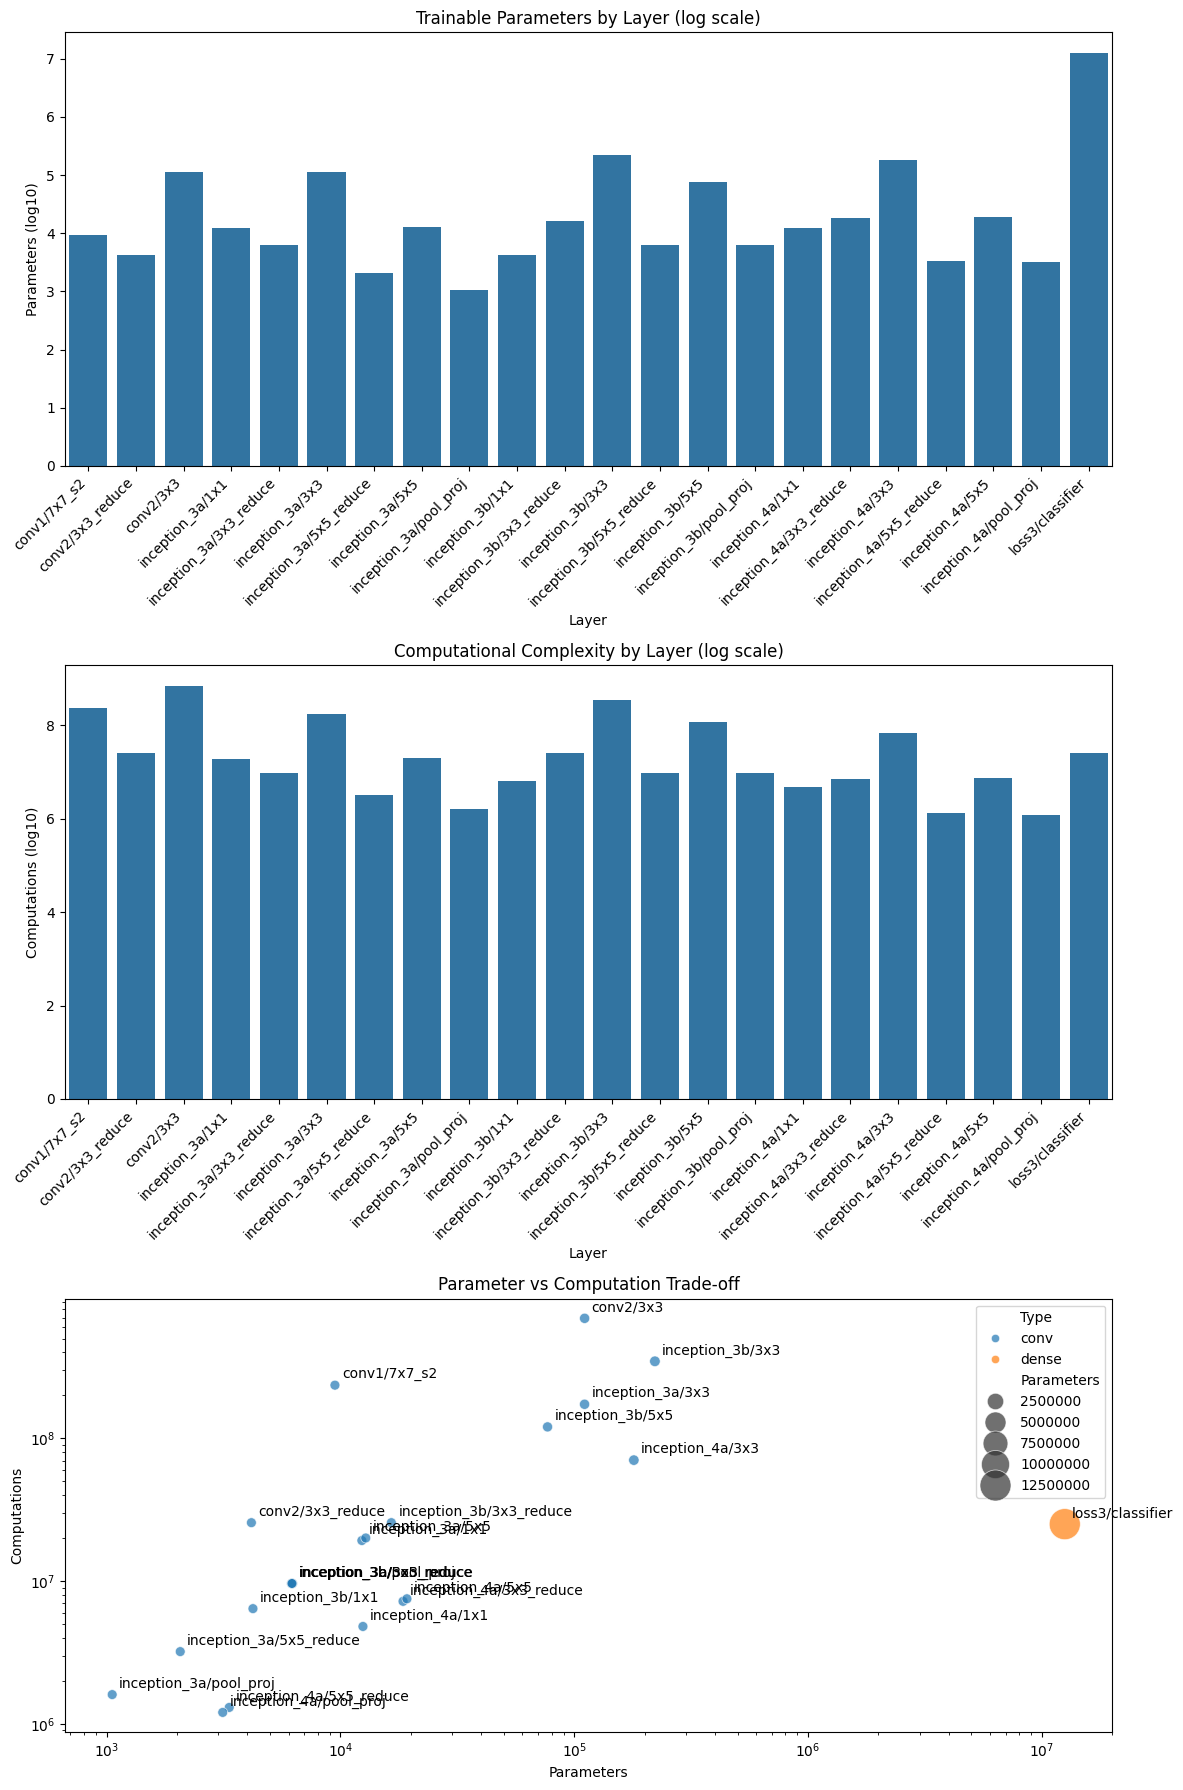

In [ ]:
# Define GoogleNet architecture (simplified for clarity)
googlenet_config = [
    # Initial layers
    {'name': 'conv1/7x7_s2', 'type': 'conv', 'filter_h': 7, 'filter_w': 7, 'stride': 2, 'padding': 3, 'num_filters': 64},
    {'name': 'pool1/3x3_s2', 'type': 'pool', 'stride': 2},
    {'name': 'conv2/3x3_reduce', 'type': 'conv', 'filter_h': 1, 'filter_w': 1, 'stride': 1, 'padding': 0, 'num_filters': 64},
    {'name': 'conv2/3x3', 'type': 'conv', 'filter_h': 3, 'filter_w': 3, 'stride': 1, 'padding': 1, 'num_filters': 192},
    {'name': 'pool2/3x3_s2', 'type': 'pool', 'stride': 2},

    # Inception 3a
    {'name': 'inception_3a/1x1', 'type': 'conv', 'filter_h': 1, 'filter_w': 1, 'stride': 1, 'padding': 0, 'num_filters': 64},
    {'name': 'inception_3a/3x3_reduce', 'type': 'conv', 'filter_h': 1, 'filter_w': 1, 'stride': 1, 'padding': 0, 'num_filters': 96},
    {'name': 'inception_3a/3x3', 'type': 'conv', 'filter_h': 3, 'filter_w': 3, 'stride': 1, 'padding': 1, 'num_filters': 128},
    {'name': 'inception_3a/5x5_reduce', 'type': 'conv', 'filter_h': 1, 'filter_w': 1, 'stride': 1, 'padding': 0, 'num_filters': 16},
    {'name': 'inception_3a/5x5', 'type': 'conv', 'filter_h': 5, 'filter_w': 5, 'stride': 1, 'padding': 2, 'num_filters': 32},
    {'name': 'inception_3a/pool_proj', 'type': 'conv', 'filter_h': 1, 'filter_w': 1, 'stride': 1, 'padding': 0, 'num_filters': 32},

    # Inception 3b
    {'name': 'inception_3b/1x1', 'type': 'conv', 'filter_h': 1, 'filter_w': 1, 'stride': 1, 'padding': 0, 'num_filters': 128},
    {'name': 'inception_3b/3x3_reduce', 'type': 'conv', 'filter_h': 1, 'filter_w': 1, 'stride': 1, 'padding': 0, 'num_filters': 128},
    {'name': 'inception_3b/3x3', 'type': 'conv', 'filter_h': 3, 'filter_w': 3, 'stride': 1, 'padding': 1, 'num_filters': 192},
    {'name': 'inception_3b/5x5_reduce', 'type': 'conv', 'filter_h': 1, 'filter_w': 1, 'stride': 1, 'padding': 0, 'num_filters': 32},
    {'name': 'inception_3b/5x5', 'type': 'conv', 'filter_h': 5, 'filter_w': 5, 'stride': 1, 'padding': 2, 'num_filters': 96},
    {'name': 'inception_3b/pool_proj', 'type': 'conv', 'filter_h': 1, 'filter_w': 1, 'stride': 1, 'padding': 0, 'num_filters': 64},

    {'name': 'pool3/3x3_s2', 'type': 'pool', 'stride': 2},

    # Inception 4a
    {'name': 'inception_4a/1x1', 'type': 'conv', 'filter_h': 1, 'filter_w': 1, 'stride': 1, 'padding': 0, 'num_filters': 192},
    {'name': 'inception_4a/3x3_reduce', 'type': 'conv', 'filter_h': 1, 'filter_w': 1, 'stride': 1, 'padding': 0, 'num_filters': 96},
    {'name': 'inception_4a/3x3', 'type': 'conv', 'filter_h': 3, 'filter_w': 3, 'stride': 1, 'padding': 1, 'num_filters': 208},
    {'name': 'inception_4a/5x5_reduce', 'type': 'conv', 'filter_h': 1, 'filter_w': 1, 'stride': 1, 'padding': 0, 'num_filters': 16},
    {'name': 'inception_4a/5x5', 'type': 'conv', 'filter_h': 5, 'filter_w': 5, 'stride': 1, 'padding': 2, 'num_filters': 48},
    {'name': 'inception_4a/pool_proj', 'type': 'conv', 'filter_h': 1, 'filter_w': 1, 'stride': 1, 'padding': 0, 'num_filters': 64},

    # Final layers (simplified)
    {'name': 'pool5/7x7_s1', 'type': 'pool', 'stride': 1},
    {'name': 'loss3/classifier', 'type': 'dense', 'num_nodes': 1000}
]

# Analyze GoogleNet architecture
googlenet_analysis = analyze_network(googlenet_config)

# Display results
print("GoogleNet Architecture Analysis")
print("=" * 80)
display(googlenet_analysis)

# Calculate total parameters and computations
total_params = googlenet_analysis['Parameters'].sum()
total_comps = googlenet_analysis['Computations'].sum()

print(f"\nTotal trainable parameters: {format_number(total_params)}")
print(f"Total computations: {format_number(total_comps)}")

# Visualize network statistics
visualize_network_stats(googlenet_analysis)



## 5. Generate Layer-by-Layer Analysis Summary



Layer Module Summary:


,Module,Parameters,Computations,Parameters (formatted),Computations (formatted)
0,conv1,9472,236027904,9.47K,236.03M
1,conv2,114944,719323136,114.94K,719.32M
2,inception_3a,145264,227196928,145.26K,227.20M
3,inception_3b,331392,518619136,331.39K,518.62M
4,inception_4a,236656,92524544,236.66K,92.52M
5,loss3,12545000,25088000,12.54M,25.09M
6,pool1,0,0,0,0
7,pool2,0,0,0,0
8,pool3,0,0,0,0
9,pool5,0,0,0,0


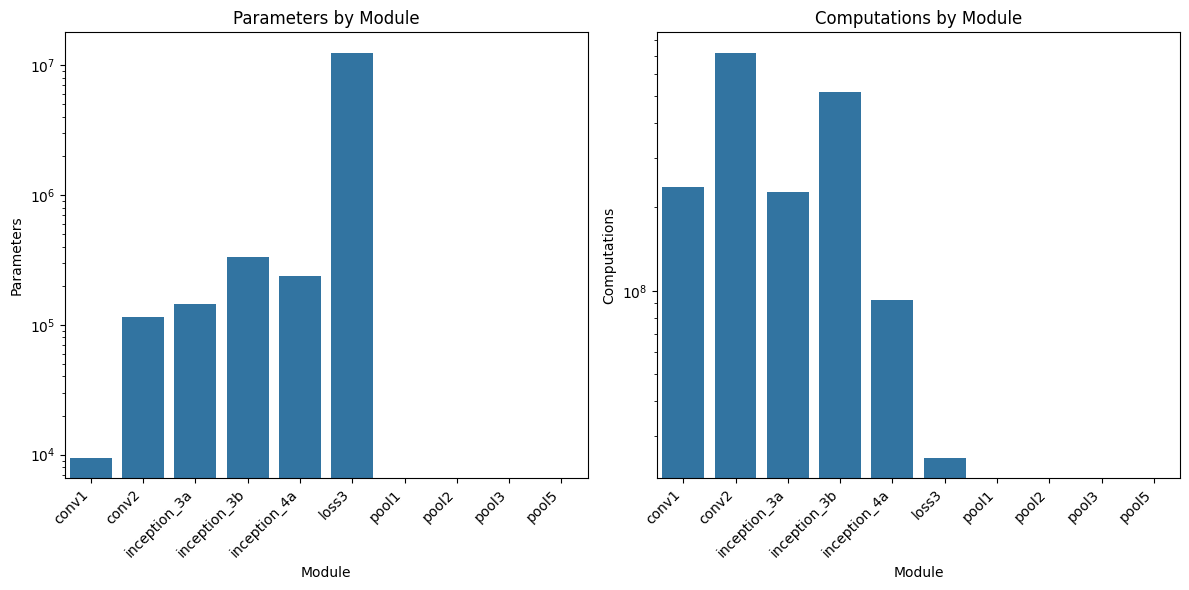

In [ ]:
def generate_layer_summary(df, group_by_module=True):
    """
    Generate a layer-by-layer summary of the network architecture.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing network analysis results
    group_by_module : bool
        Whether to group layers by module (e.g., inception blocks)

    Returns:
    --------
    pd.DataFrame
        Summarized DataFrame
    """
    if group_by_module:
        # Extract module name (e.g., 'inception_3a' from 'inception_3a/1x1')
        df['Module'] = df['Layer'].apply(lambda x: x.split('/')[0] if '/' in x else x)

        # Group by module
        grouped = df.groupby('Module').agg({
            'Parameters': 'sum',
            'Computations': 'sum'
        }).reset_index()

        # Format numbers
        grouped['Parameters (formatted)'] = grouped['Parameters'].apply(format_number)
        grouped['Computations (formatted)'] = grouped['Computations'].apply(format_number)

        return grouped
    else:
        return df

# Generate and display summary
module_summary = generate_layer_summary(googlenet_analysis)
print("\nLayer Module Summary:")
print("=" * 50)
display(module_summary)

# Plot module summary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Module', y='Parameters', data=module_summary)
plt.title('Parameters by Module')
plt.yscale('log')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
sns.barplot(x='Module', y='Computations', data=module_summary)
plt.title('Computations by Module')
plt.yscale('log')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


## 6. Visualize Module Architecture

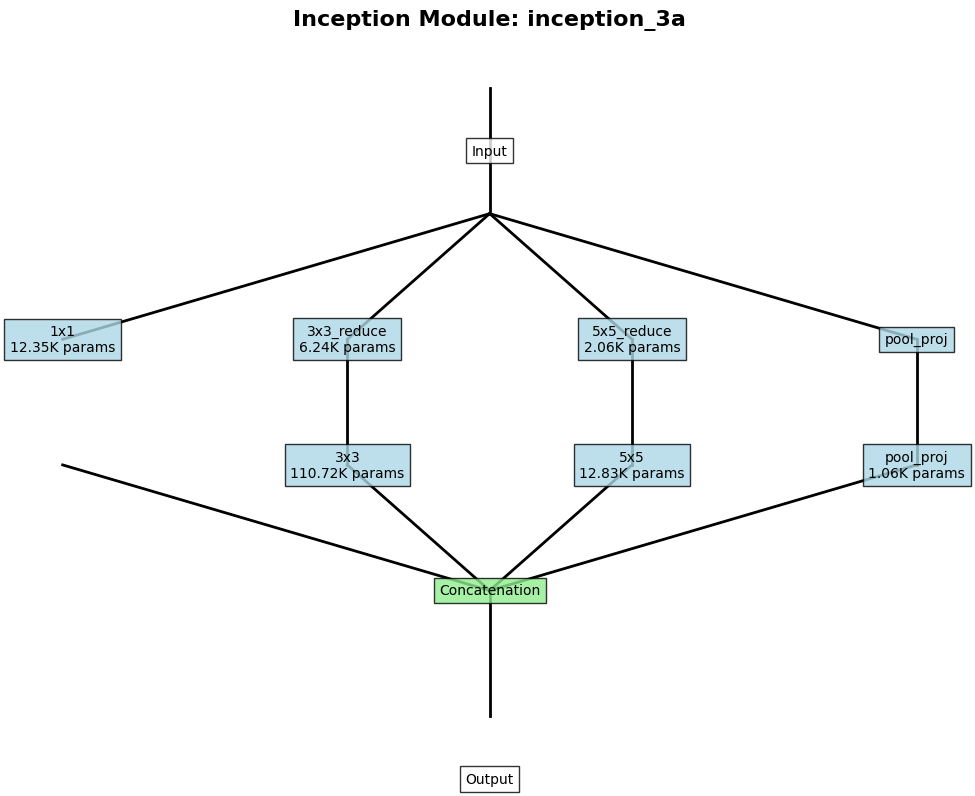

In [ ]:
def visualize_inception_module(module_name="inception_3a"):
    """
    Create a visual representation of an inception module.

    Parameters:
    -----------
    module_name : str
        Name of the inception module to visualize
    """
    plt.figure(figsize=(10, 8))

    # Filter layers in this module
    module_layers = googlenet_analysis[googlenet_analysis['Layer'].str.startswith(module_name)]

    # Draw the module architecture
    plt.text(0.5, 0.95, f"Inception Module: {module_name}", ha='center', fontsize=16, fontweight='bold')

    # Input
    plt.plot([0.5, 0.5], [0.9, 0.8], 'k-', linewidth=2)
    plt.text(0.5, 0.85, "Input", ha='center', va='center', bbox=dict(facecolor='white', alpha=0.8))

    # Four parallel paths
    paths = [
        f"{module_name}/1x1",
        [f"{module_name}/3x3_reduce", f"{module_name}/3x3"],
        [f"{module_name}/5x5_reduce", f"{module_name}/5x5"],
        [f"{module_name}/pool", f"{module_name}/pool_proj"]
    ]

    # Draw paths
    x_positions = [0.2, 0.4, 0.6, 0.8]
    for i, path in enumerate(paths):
        x = x_positions[i]

        # Draw the path
        plt.plot([0.5, x], [0.8, 0.7], 'k-', linewidth=2)

        if isinstance(path, list):
            # Multiple layers in this path
            for j, layer_name in enumerate(path):
                y = 0.7 - j*0.1
                y_next = y - 0.1

                # Find layer in our analysis
                layer = module_layers[module_layers['Layer'] == layer_name]
                if not layer.empty:
                    layer_info = layer.iloc[0]
                    params = format_number(layer_info['Parameters'])
                    comps = format_number(layer_info['Computations'])
                    plt.text(x, y, f"{layer_name.split('/')[-1]}\n{params} params",
                            ha='center', va='center', bbox=dict(facecolor='lightblue', alpha=0.8))
                else:
                    plt.text(x, y, f"{path[-1].split('/')[-1]}",
                            ha='center', va='center', bbox=dict(facecolor='lightblue', alpha=0.8))

                if j < len(path) - 1:
                    plt.plot([x, x], [y, y_next], 'k-', linewidth=2)
        else:
            # Single layer
            layer = module_layers[module_layers['Layer'] == path]
            if not layer.empty:
                layer_info = layer.iloc[0]
                params = format_number(layer_info['Parameters'])
                comps = format_number(layer_info['Computations'])
                plt.text(x, 0.7, f"{path.split('/')[-1]}\n{params} params",
                        ha='center', va='center', bbox=dict(facecolor='lightblue', alpha=0.8))
            else:
                plt.text(x, 0.7, f"{path.split('/')[-1]}",
                        ha='center', va='center', bbox=dict(facecolor='lightblue', alpha=0.8))

    # Output concat
    for i, x in enumerate(x_positions):
        plt.plot([x, 0.5], [0.6, 0.5], 'k-', linewidth=2)

    plt.text(0.5, 0.5, "Concatenation", ha='center', va='center',
             bbox=dict(facecolor='lightgreen', alpha=0.8))

    plt.plot([0.5, 0.5], [0.5, 0.4], 'k-', linewidth=2)
    plt.text(0.5, 0.35, "Output", ha='center', va='center', bbox=dict(facecolor='white', alpha=0.8))

    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize an inception module
visualize_inception_module("inception_3a")


## 7. Export Results

In [ ]:
def export_results(df, filename="googlenet_analysis.csv"):
    """
    Export analysis results to a CSV file.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing network analysis results
    filename : str
        Name of the CSV file to export
    """
    df.to_csv(filename, index=False)
    print(f"Results exported to {filename}")

# Export results to CSV
export_results(googlenet_analysis)

# Format and display final summary
formatted_summary = googlenet_analysis.copy()
formatted_summary['Parameters'] = formatted_summary['Parameters'].apply(format_number)
formatted_summary['Computations'] = formatted_summary['Computations'].apply(format_number)
formatted_summary['Dot Products'] = formatted_summary['Dot Products'].apply(format_number)

display(Markdown("# GoogleNet Architecture Summary"))
display(formatted_summary[['Layer', 'Type', 'Input Dim', 'Output Dim', 'Parameters', 'Computations']])


Results exported to googlenet_analysis.csv


# GoogleNet Architecture Summary

,Layer,Type,Input Dim,Output Dim,Parameters,Computations
0,conv1/7x7_s2,conv,112×112×64,112×112×64,9.47K,236.03M
1,pool1/3x3_s2,pool,56×56×64,56×56×64,0,0
2,conv2/3x3_reduce,conv,56×56×64,56×56×64,4.16K,25.69M
3,conv2/3x3,conv,56×56×192,56×56×192,110.78K,693.63M
4,pool2/3x3_s2,pool,28×28×192,28×28×192,0,0
5,inception_3a/1x1,conv,28×28×64,28×28×64,12.35K,19.27M
6,inception_3a/3x3_reduce,conv,28×28×96,28×28×96,6.24K,9.63M
7,inception_3a/3x3,conv,28×28×128,28×28×128,110.72K,173.41M
8,inception_3a/5x5_reduce,conv,28×28×16,28×28×16,2.06K,3.21M
9,inception_3a/5x5,conv,28×28×32,28×28×32,12.83K,20.07M


## 8. Conclusion

This notebook demonstrates a comprehensive analysis of neural network architectures, focusing on the GoogleNet model. The implemented function successfully calculates:

1. **Output dimensions** for each layer
2. **Number of trainable parameters** (weights and biases)
3. **Number of dot products** performed per forward pass
4. **Total computational load** in terms of additions and multiplications

The analysis reveals that GoogleNet achieves high performance with a relatively modest parameter count by using inception modules that efficiently distribute computation across multiple filter sizes.

## 9. References

- Szegedy, C., Liu, W., Jia, Y., Sermanet, P., Reed, S., Anguelov, D., ... & Rabinovich, A. (2015). Going deeper with convolutions. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 1-9).
- He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).
